<a href="https://colab.research.google.com/github/MishterBluesky/MIP/blob/master/Chris_Stansfeld_Co_EVfold_AlphaFold2_trRosetta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<img src="https://warwick.ac.uk/fac/cross_fac/howard-dalton-centre/hdc_logo_black_sm.png" height="200" align="right" style="height:240px">

##CoEvFold: AlphaFold2 and trRosetta Co-evolution mapping using MMseqs2

Co-evolution, and Structure Module. Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). Follow the instructions and steps to produce multimer models, with co-evolution contacts visualised.

This is based heavily on ColabFold and trRosetta For more details on the backbone of this "ColabFold", see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read the manuscript of the Colab fold creators.

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

This co-lab extension variant by the Stansfeld lab [Howard Dalton Centre](https://warwick.ac.uk/fac/cross_fac/howard-dalton-centre/) and University of Warwick Rodrigues members contains an increased element of co-evolution and protein coupling, with integrations for fully understanding a protein, its conservation and the intra as well as potential inter-molecular contacts with the input sequence

Please note that errors at the paired.npz step are likely caused by RAM limits, and are only avoidable with smaller input requests, or by using a RAM only setup in options. **Total amino acid limit 900**

In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MLKKGPAVIG ATCLTSALLL SGCGLFQSDK AAEEIDPPQD VTFVNDEAGA NSNTTAAKKT ESEKSDTAKA DQASSTVMRE LYLIDKNGYV VAQTLPLPKS ESTAKQALEY LVQGGPVSEI LPNGFRAVLP ADTTVNVDIK  KDGTAIADFS NEFKNYKKED EQKIVQSVTW TLTQFSSIDK VKLRINGHEL KEMPVGGTPI SDDLSRKDGI NLETAGVNDL TATHPLTVYY LAENEDSEYY VPVTKRIDNS EKDDITAAIN ELAKGPSKVS GLLTDFSEDV  KLVSKPKIKD GRVTLDFNQS IFGSADEKTK MISSEVLNSI VLTLTEQPDV KSVSVKVNGK SELVNEKGEK LTEPVSRPSQ VNTGSF' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'GerM' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "pdb100" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



jobname GerM_2755a
sequence MLKKGPAVIGATCLTSALLLSGCGLFQSDKAAEEIDPPQDVTFVNDEAGANSNTTAAKKTESEKSDTAKADQASSTVMRELYLIDKNGYVVAQTLPLPKSESTAKQALEYLVQGGPVSEILPNGFRAVLPADTTVNVDIKKDGTAIADFSNEFKNYKKEDEQKIVQSVTWTLTQFSSIDKVKLRINGHELKEMPVGGTPISDDLSRKDGINLETAGVNDLTATHPLTVYYLAENEDSEYYVPVTKRIDNSEKDDITAAINELAKGPSKVSGLLTDFSEDVKLVSKPKIKDGRVTLDFNQSIFGSADEKTKMISSEVLNSIVLTLTEQPDVKSVSVKVNGKSELVNEKGEKLTEPVSRPSQVNTGSF
length 366


In [2]:
#@markdown ### Install Dependencies

%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version


if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

!python -m pip install --upgrade pip
!pip install tr-rosetta-pytorch
!apt-get install pymol
!touch TRROSETTA_READY

installing colabfold...
installing conda...
installing hhsuite...
  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 102.5 MB/s eta 0:00:

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apbs apbs-data freeglut3 libapbs3 libevdev2 libglu1-mesa libgudev-1.0-0 libinput-bin libinput10
  libmaloc1 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5designer5 libqt5gui5 libqt5help5
  libqt5network5 libqt5opengl5 libqt5printsupport5 libqt5sql5 libqt5sql5-sqlite libqt5svg5
  libqt5test5 libqt5widgets5 libqt5xml5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4
  libxcb-image0 libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0
  libxcb-xkb1 libxkbcommon-x11-0 pymol-data python3-numpy python3-opengl python3-pymol
  python3-pyqt5 python3-pyqt5.qtopengl python3-pyqt5.sip qt5-gtk-platformtheme qttranslations5-l10n
Suggested packages:
  qt5-image-formats-plugins qtwayland5 python-numpy-doc python3-pytest libgle3
The following NEW packages will be installed:
  apbs apbs-data freeglut3 libapbs3 libevdev

In [3]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "1" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use 20 recycles if `model_type=alphafold2_multimer_v3` (with tol=0.5), all else 3 recycles (with tol=0.0).
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2023-10-31 12:52:28,840 Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
2023-10-31 12:52:28,841 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2023-10-31 12:52:34,013 Running on GPU
2023-10-31 12:52:34,236 Found 7 citations for tools or databases
2023-10-31 12:52:34,237 Query 1/1: GerM_2755a (length 366)
2023-10-31 12:52:34,238 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


2023-10-31 12:52:44,231 Sequence 0 found templates: ['6gzb_B', '6gzb_D', '6gz8_A', '6gzb_B', '5j7r_C', '6gzb_D', '6gzb_B', '6gzb_D', '5j7r_C', '6gz8_A']
2023-10-31 12:52:44,232 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


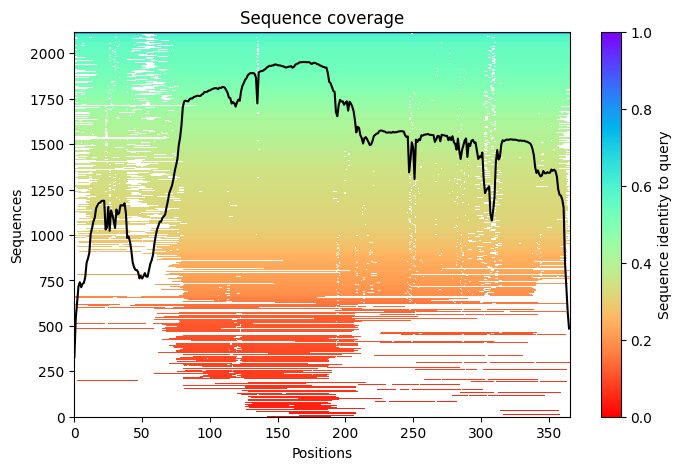

2023-10-31 12:52:45,725 Setting max_seq=512, max_extra_seq=1610
2023-10-31 12:54:36,940 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=82.6 pTM=0.766
2023-10-31 12:55:15,280 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=82.9 pTM=0.771 tol=3.78
2023-10-31 12:55:15,283 alphafold2_ptm_model_1_seed_000 took 128.4s (1 recycles)


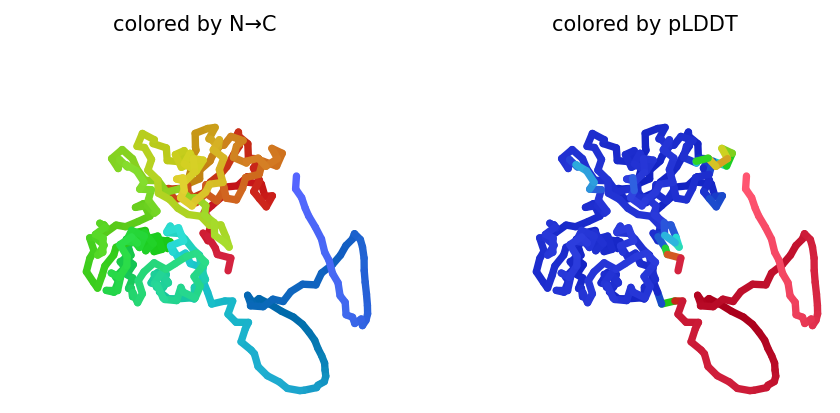

2023-10-31 12:55:16,015 reranking models by 'plddt' metric
2023-10-31 12:55:16,016 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=82.9 pTM=0.771
2023-10-31 12:55:17,087 Done


0

In [5]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=1,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=True,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [8]:
#@title Checkpoint - (Run if error on next step) Unzip previous files
#@markdown This step allows the following steps to work, if you reinstall dependencies and repeat the first input steps. It can be useful if your runtime times out after a job. You can even re-upload previous results into your directory to analyse for co-evolution. (The following steps).
!os.chdir("/content")
!unzip -o {jobname}.result.zip


/bin/bash: -c: line 1: syntax error near unexpected token `"/content"'
/bin/bash: -c: line 1: `os.chdir("/content")'
Archive:  GerM_2755a.result.zip
 extracting: GerM_2755a_coverage.png  
 extracting: GerM_2755a_template_domain_names.json  
 extracting: GerM_2755a.a3m          
 extracting: cite.bibtex             
 extracting: config.json             
 extracting: GerM_2755a_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb  
 extracting: GerM_2755a_scores_rank_001_alphafold2_ptm_model_1_seed_000.json  
 extracting: GerM_2755a_predicted_aligned_error_v1.json  
 extracting: GerM_2755a_pae.png      
 extracting: GerM_2755a_plddt.png    


In [7]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
os.chdir('../')
os.chdir('../')
os.chdir("/content")
os.chdir(f"/content/{jobname}")
rank_num = 4 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = True #@param {type:"boolean"}
show_mainchains = True #@param {type:"boolean"}
jobname_prefix = ".custom" if msa_mode == "custom" else ""
if use_amber:
  pdb_filename = f"{jobname}{jobname_prefix}_relaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb"
else:
  pdb_filename = f"{jobname}{jobname_prefix}_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb"

  pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_filename,'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view


show_pdb(rank_num,show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

FileNotFoundError: ignored

In [ ]:
#@title Plots {run: "auto"}
#@markdown This function prints plots using values that AlphaFold creates. Coverage is how many sequences are aligned per residue, plddt and PAE are confidence values.
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(f"{jobname}{jobname_prefix}_pae.png")
cov = image_to_data_url(f"{jobname}{jobname_prefix}_coverage.png")
plddt = image_to_data_url(f"{jobname}{jobname_prefix}_plddt.png")
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


In [ ]:
#@title Run TrRosetta and Create Align files: Required for later steps.
#@markdown This step produces no output useful for visualisation or reading, however is required for the weblogo, and tRosetta functions that follow. If there is an error, check the paired.npz file was correctly created. RAM limitations may cause this to fail. This step should take 2mins+ at least. If you have no output and really need to look at a large assembly, try loading the .a3m file in your environment to the CoEVfold RAM bypass colab: https://colab.research.google.com/drive/1O5GRALaMjszSdHk8WrXgdgS3vAZndNc-?usp=sharing this will enable you to run the tr_Rosetta calculations with an empty RAM. Once this is finished, add the .npz file created to the environment here.
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()
os.chdir(f"/content/{jobname}/")
!egrep -v '#|>' /content/{jobname}/{jobname}.a3m | sed 's/[a-z]//g' | sort -u > paired.aln
!tr_rosetta paired.aln


In [ ]:
#@title Run Visualise trRosetta plot - a co-evolution approximation { display-mode: "form" }
#@markdown This function makes a 2D average map, with residue co-evolution values shown. It is these values later used and thresholded for the .pse file.
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]
#@markdown Please add a threshold between 0.005 and 0.99, the higher the threshold the higher the required co-evolution between residues to be visible. You can see an inter molecular link will be lower than an intra.
trRosetta_threshold = 0.03 #@param {type:"number"}
#@markdown - We **recommend** a threshold of 0.2, as does trRosetta. This code will create a .pse file , which you can open using PyMol. This is made using the output_file in the "Contents" folder.
seq1 = len(query_sequence.split(':')[0])
import numpy as np
from numpy import load
import pandas as pd
data = np.load('paired.npz', allow_pickle=True)

w = np.sum(data['dist'][:,:,1:13], axis=-1)
L = w.shape[0]
idx = np.array([[i+1,j+1,0,8,w[i,j]] for i in range(L) for j in range(i+5,L)])
out = idx[np.flip(np.argsort(idx[:,4]))]

data2 = [out[:,0].astype(int), out[:,1].astype(int), out[:,4].astype(float)]

df = pd.DataFrame(data2)
df = df.transpose()

df[0] = df[0].astype(int)
df[1] = df[1].astype(int)
df.columns = ["A", "B", "Score"]
df.to_csv('out_file.csv', sep=' ', index=False)

df = df[(df['A'] < seq1) & (df['B'] >= seq1) & (df['B'] - df['A'] > 5 ) & (df['Score'] > trRosetta_threshold)]
df = df.sub([0,seq1,0])
df = df.sort_values('Score',ascending=False)
df = df.reset_index()
del df['index']
df.to_csv('sorted_file.csv', sep=' ', index=False)
print(df)

pml=open(f'{jobname}{jobname_prefix}.pml','w')
pml.write(f"load {jobname}{jobname_prefix}_unrelaxed_rank_1_model_1.pdb\n")
for i in range(0, len(df)):
  pml.write(f"distance {df['A'][i]}-{df['B'][i]}, i. {df['A'][i]} and name CA and chain B, i. {df['B'][i]} and name CA and chain C\n")
pml.write("bg white\ncolor lightblue, chain B and pol\ncolor paleyellow, chain C and pol\nset dash_radius,0.5\nas cartoon\nhide labels\ncolor palegreen, *-*\n\nshow dashes")
pml.write("\nalter resname ALA, b=-0.13692946\nalter resname ARG, b=-0.41493776\nalter resname ASN, b=-0.17842324\nalter resname ASP, b=-1.00000000\nalter resname CYS, b=-0.09128631\nalter resname GLN, b=-0.07883817\nalter resname GLU, b=-0.66804979\nalter resname GLY, b=-0.47302905\nalter resname HIS, b=-0.56846473\nalter resname ILE, b=0.33609959\nalter resname LEU, b=0.28630705\nalter resname LYS, b=-0.75103734\nalter resname MET, b=0.18257261\nalter resname PHE, b=0.24066390\nalter resname PRO, b=0.12863071\nalter resname SER, b=-0.13692946\nalter resname THR, b=-0.04564315\nalter resname TRP, b=0.09958506\nalter resname TYR, b=-0.09543568\nalter resname VAL, b=0.21991701\n")
def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="rainbow"):
  model_name = f"rank_{rank_num}"
pml.close()

fig = plt.figure()
fig.set_size_inches(15,15)
plt.axvline(x = seq1)
plt.axhline(y = seq1)

#plt.scatter(data2[0],data2[1],s=data2[2]*100)

plt.imshow(w, cmap='binary', vmin=0, vmax=0.3)
plt.show()


In [ ]:
#@title Visualise and download highly scoring trRosetta interactions { display-mode: "form" }
import pandas as pd
from google.colab import files
!conda install -c conda-forge pymol-open-source -y
!conda install -c conda-forge tqdm -y
os.chdir(f"/content/{jobname}/")
df = pd.read_csv('sorted_file.csv', delimiter=' ')
print(df.columns)  # Print column names to verify

#@markdown Please add a threshold between 0.005 and 0.99, the higher the threshold the higher the required co-evolution between residues to be visible. You can see an inter molecular link will be lower than an intra.
trRosetta_threshold = 0.03 #@param {type:"number"}
#@markdown - We **recommend** a threshold of 0.2, as does trRosetta. This code will create a .pse file , which you can open using PyMol. This is made using the output_file in the "Contents" folder.

# Extract the relevant columns
residue_pairs_df = df[df['Score'] > trRosetta_threshold][['A', 'B']]
residue_pairs_df.to_csv('residues_above_threshold.csv', index=False)

# Generate PyMOL script
os.chdir(f"/content/{jobname}/")
pym_script = []
pym_script.append(f"cmd.load('{jobname}_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb')")
pym_script.append('cmd.color("gray90")')
pym_script.append('cmd.cartoon("automatic")')
pym_script.append('cmd.set("dash_radius", 0.4)')
pym_script.append('cmd.set("dash_color", "red")')
pym_script.append('cmd.bg_color("white")')

# Load the residue pairs from residues_above_threshold.csv
selected_residue_pairs = pd.read_csv('residues_above_threshold.csv')

for index, row in selected_residue_pairs.iterrows():
    res_A = row['A']
    res_B = row['B']

    # Add distance to PyMOL script for each residue pair
    pym_script.append(f'cmd.distance("{res_A}-{res_B}", "resi {res_A} and name CA and chain A", "resi {res_B} and name CA and chain B")')

pym_script.append(f'cmd.save("{jobname}.pse")')

# Write the PyMOL script to a file
with open(f"{jobname}.py", 'w') as pym_script_file:
    pym_script_file.write('\n'.join(pym_script))

# Load the PyMOL script
pym_script_filename = f"{jobname}.py"
!pymol -cq {jobname}.py

# Save the created as a .pse file
pse_filename = f"{jobname}.pse"

# Download the .pse file
files.download(f"{jobname}.pse")


In [ ]:
%%capture
#@title Calculate inter-residue distances from the alphafold model (using Pymol) and write a csv file containing these.

#open the uploaded pdb file

file = open(f'{jobname}{jobname_prefix}_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb', 'r')
data = file.readlines()

#make a list containing the coordinate data

data_list=[]

for i in range(0,len(data)):
  current_line=data[i]
  if current_line[0:6].strip()=='ATOM' and current_line[12:16].strip()=='CA':
    chain=str(current_line[21:22].strip())
    residue=int(current_line[22:26].strip())
    xcoord=float(current_line[30:38].strip())
    ycoord=float(current_line[38:46].strip())
    zcoord=float(current_line[46:54].strip())
    myatomrecord=(chain, residue, xcoord, ycoord, zcoord)
    data_list.append(myatomrecord)
  else:
    pass

#calculate interatomic distances for c-alpha positions of each residue pair and put them in a 2d nested list

my_distance_data=[]

for i in range(0,len(data_list)):
  k_list=[]
  for k in range(0,len(data_list)):
    record1=data_list[i]
    record2=data_list[k]
    atom1=(record1[2], record1[3], record1[4])
    atom2=(record2[2], record1[3], record1[4])
    xdistance=abs(atom1[0]-atom2[0])
    ydistance=abs(atom1[1]-atom2[1])
    zdistance=abs(atom1[2]-atom2[2])
    distance=pow((pow(xdistance,2) + pow(ydistance,2) + pow(zdistance,2)),0.5)
    k_list.append("%f"%(distance))
  my_distance_data.append(k_list)

#write out a csv file

output_csv_file=open('interresidue_distances_from_AF_pdb.csv','w') #mightneed to direct this to the outpout folder later!

for i in range(0, len(my_distance_data)):
  output_csv_file.write(", ".join(my_distance_data[i]))
  output_csv_file.write("\n")

output_csv_file.close()

file.close()


In [ ]:
#@title Plot the inter-residue distances to compare against the trRosetta coevo plot.
import matplotlib.pyplot as plt
from math import log, sqrt, pow, exp

#read in the csv as an input file
input_csv_file_name="interresidue_distances_from_AF_pdb.csv"
my_data = np.genfromtxt(input_csv_file_name, delimiter=',')

closest=1

for i in range(0,len(my_data)):
  for k in range(0,len(my_data)):
    if my_data[i][k]>=closest:
#      #my_data[i][k]=1/(1+(my_data[i][k] - closest))
      my_data[i][k]=sqrt(1/(1+(my_data[i][k] - closest)))
#      my_data[i][k]=log(1/(1+(my_data[i][k] - closest)))
      #my_data[i][k]=-1*log(my_data[i][k])

    else:
      my_data[i][k]=1

#plot the coevo data as a heatmap
fig = plt.figure()
fig.set_size_inches(15,15)
plt.imshow(my_data, cmap='binary',vmin=0, vmax=1)
plt.show()

In [ ]:
#@title Measure AlphaFold interface surface area with Pymol.
!conda install -c conda-forge pymol-open-source -y
mysascript=open('mysascript.py','w')
mysascript.write(f'from pymol import cmd\n')
mysascript.write(f"cmd.load('{jobname}{jobname_prefix}_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb')\n")
mysascript.write(f"cmd.create('molB','/{jobname}{jobname_prefix}_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000//B/')\n")
mysascript.write(f"cmd.create('molC','/{jobname}{jobname_prefix}_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000//C/')\n")
mysascript.write(f"cmd.center('{jobname}{jobname_prefix}_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000')\n")

mysascript.write("cmd.set('dot_solvent',1)\n")
mysascript.write("cmd.set('solvent_radius',1.4)\n")
mysascript.write(f"area_complex=cmd.get_area('{jobname}{jobname_prefix}_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000')\n")
mysascript.write("area_first_monomer=cmd.get_area('molB')\n")
mysascript.write("area_second_monomer=cmd.get_area('molC')\n")
mysascript.write("interface_area=(area_first_monomer+area_second_monomer)-area_complex\n")
mysascript.write("print(('Surface area of the complex        : %8d A^2')%(area_complex))\n")
mysascript.write("print(('Surface area of the first monomer  : %8d A^2')%(area_first_monomer))\n")
mysascript.write("print(('Surface area of the second monomer : %8d A^2')%(area_second_monomer))\n")
mysascript.write("print(('Interface area                     : %8d A^2')%(interface_area))\n")


mysascript.write("cmd.quit()\n")
mysascript.close()
!pymol -cq mysascript.py

In [ ]:
#@title Package and download results
#@markdown This only downloads one model, unlike normal alphaFold, use the .pse file to determine if your interactions are true or not. If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")
os.chdir(f"/content")
files.download(f"{jobname}.result.zip")
os.chdir(f"/content/{jobname}")
files.download("sorted_file.csv")
files.download("out_file.csv")
files.download("interresidue_distances_from_AF_pdb.csv")
files.download('residues_above_threshold.csv')
files.download(f"{jobname}.pse")
if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}_part_2.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

# Instructions <a name="Instructions"></a>
**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to proide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and Alphafold2 colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [preprint](https://www.biorxiv.org/content/10.1101/2021.08.15.456425v1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).
*The pipeline with trRosetta does save results which can then be completed asynchronously but to work must complete at least to the display 3D structure step.
*One must run the pipeline in order, due to dependencies.

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [Phillip Stansfeld](https://warwick.ac.uk/fac/sci/lifesci/people/pstansfeld/) and [Chris LB Graham](https://twitter.com/ChrisLBGraham)  for creating and editing the co-evolution trRosetta contact visualisation pipeline including Co-evolution contacts, Weblogo etc

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)), Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)), then [Phillip Stansfeld](https://warwick.ac.uk/fac/sci/lifesci/people/pstansfeld/) and [@ChrisLBGraham](https://twitter.com/ChrisLBGraham)
